In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline

import flotilla


flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'

study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)

# not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2017-01-13 08:42:48	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2017-01-13 08:42:48	Parsing datapackage to create a Study object
https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2017-01-13 08:43:29 	Initializing Study
2017-01-13 08:43:29 	Initializing Predictor configuration manager for Study
2017-01-13 08:43:29	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2017-01-13 08:43:29	Added ExtraTreesClassifier to default predictors
2017-01-13 08:43:29	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2017-01-13 08:43:29	Added ExtraTreesRegressor to default predictors
2017-01-13 08:43:29	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradien

Error loading species hg19 data: HTTP Error 404: Not Found

In [5]:
folder = 'figures/002_modality_calculation_with_outliers'
! mkdir $folder

mkdir: cannot create directory `figures/002_modality_calculation_with_outliers': File exists


## Estimate modalities

### Initialize the modality estimator

In [6]:
import anchor

bayesian = anchor.BayesianModalities()
# binned = anchor.BinnedModalities()
# monte_carlo = anchor.MonteCarloModalities()

## Calculate/Estimate modalities only on single cells, with no outliers

And at least 10 cells per splicing event, per celltype/phenotype

In [7]:
study.splicing.minimum_samples

10

In [8]:
print(study.splicing.singles.shape)
splicing_singles = study.splicing.singles.groupby(
    study.sample_id_to_phenotype).apply(lambda x: x.dropna(thresh=study.splicing.minimum_samples, axis=1))
print splicing_singles.shape

(291, 17978)
(291, 13966)


In [9]:
pkm_events = study.splicing.maybe_renamed_to_feature_id('PKM')

In [10]:
%time modality_assignments = splicing_singles.groupby(study.sample_id_to_phenotype).apply(bayesian.fit_predict)

CPU times: user 40min 59s, sys: 2.61 s, total: 41min 2s
Wall time: 1h 25min 34s


In [11]:
modality_assignments

,isoform1=junction:chr10:100189400-100190327:-|isoform2=junction:chr10:100189647-100190327:-@exon:chr10:100189548-100189646:-@junction:chr10:100189400-100189547:-,isoform1=junction:chr10:100193849-100195391:-|isoform2=junction:chr10:100195172-100195391:-@exon:chr10:100195029-100195171:-@junction:chr10:100193849-100195028:-,isoform1=junction:chr10:101163392-101165512:-|isoform2=junction:chr10:101163632-101165512:-@exon:chr10:101163481-101163631:-@junction:chr10:101163392-101163480:-,isoform1=junction:chr10:101476219-101480743:-|isoform2=junction:chr10:101478258-101480743:-@exon:chr10:101478103-101478257:-@junction:chr10:101476219-101478102:-,isoform1=junction:chr10:101507148-101514285:+|isoform2=junction:chr10:101507148-101510125:+@exon:chr10:101510126-101510153:+@junction:chr10:101510154-101514285:+,isoform1=junction:chr10:101507148-101515381:+|isoform2=junction:chr10:101507148-101514285:+@exon:chr10:101514286-101514391:+@junction:chr10:101514392-101515381:+,isoform1=junction:chr10:101510154-101514285:+|isoform2=junction:chr10:101510154-101513352:+@novel_exon:chr10:101513353-101513445:+@junction:chr10:101513446-101514285:+,isoform1=junction:chr10:101995522-101997778:-|isoform2=junction:chr10:101996727-101997778:-@exon:chr10:101996607-101996726:-@junction:chr10:101995522-101996606:-,isoform1=junction:chr10:101996727-102003454:-|isoform2=junction:chr10:101997989-102003454:-@exon:chr10:101997779-101997988:-@junction:chr10:101996727-101997778:-,isoform1=junction:chr10:102006693-102013177:-|isoform2=junction:chr10:102010090-102013177:-@exon:chr10:102010005-102010089:-@junction:chr10:102006693-102010004:-,...,isoform1=junction:chrY:21897637-21903203:-|isoform2=junction:chrY:21901549-21903203:-@exon:chrY:21901414-21901548:-@junction:chrY:21897637-21901413:-,isoform1=junction:chrY:21901549-21903620:-|isoform2=junction:chrY:21903375-21903620:-@exon:chrY:21903204-21903374:-@junction:chrY:21901549-21903203:-,isoform1=junction:chrY:22744580-22749909:+|isoform2=junction:chrY:22744580-22746359:+@exon:chrY:22746360-22746410:+@junction:chrY:22746411-22749909:+,isoform1=junction:chrY:2709669-2712117:+|isoform2=junction:chrY:2709669-2710205:+@exon:chrY:2710206-2710283:+@junction:chrY:2710284-2712117:+,isoform1=junction:chrY:2710284-2713686:+|isoform2=junction:chrY:2710284-2712117:+@exon:chrY:2712118-2712298:+@junction:chrY:2712299-2713686:+,isoform1=junction:chrY:2712299-2722640:+|isoform2=junction:chrY:2712299-2713686:+@exon:chrY:2713687-2713784:+@junction:chrY:2713785-2722640:+,isoform1=junction:chrY:2713785-2722640:+|isoform2=junction:chrY:2713785-2721709:+@novel_exon:chrY:2721710-2721732:+@junction:chrY:2721733-2722640:+,isoform1=junction:chrY:2713785-2733128:+|isoform2=junction:chrY:2713785-2722640:+@exon:chrY:2722641-2722812:+@junction:chrY:2722813-2733128:+,isoform1=junction:chrY:2722813-2734833:+|isoform2=junction:chrY:2722813-2733128:+@exon:chrY:2733129-2733286:+@junction:chrY:2733287-2734833:+,isoform1=junction:chrY:2822039-2843135:+|isoform2=junction:chrY:2822039-2829114:+@exon:chrY:2829115-2829687:+@junction:chrY:2829688-2843135:+
phenotype,,,,,,,,,,,,,,,,,,,,,
MN,NaN,NaN,included,bimodal,bimodal,NaN,excluded,NaN,NaN,NaN,...,NaN,NaN,included,included,included,included,excluded,included,included,NaN
NPC,NaN,NaN,included,bimodal,bimodal,NaN,excluded,bimodal,NaN,NaN,...,NaN,NaN,included,included,included,included,excluded,included,included,NaN
iPSC,bimodal,bimodal,included,included,bimodal,included,excluded,included,included,included,...,bimodal,bimodal,included,included,included,included,excluded,included,included,bimodal


In [12]:
modalities_tidy = modality_assignments.stack().reset_index()
modalities_tidy = modalities_tidy.rename(columns={'level_1': 'event_id', 0: "modality",})
modalities_tidy.head()

,phenotype,event_id,modality
0,MN,isoform1=junction:chr10:101163392-101165512:-|...,included
1,MN,isoform1=junction:chr10:101476219-101480743:-|...,bimodal
2,MN,isoform1=junction:chr10:101507148-101514285:+|...,bimodal
3,MN,isoform1=junction:chr10:101510154-101514285:+|...,excluded
4,MN,isoform1=junction:chr10:102010090-102013177:-|...,excluded


In [13]:
modalities_tidy.loc[modalities_tidy.event_id.isin(pkm_events)]

,phenotype,event_id,modality
2075,MN,isoform1=junction:chr15:72492997-72499068:-|is...,included
2076,MN,isoform1=junction:chr15:72492997-72499068:-|is...,included
2077,MN,isoform1=junction:chr15:72494962-72499068:-@ex...,bimodal
2078,MN,isoform1=junction:chr15:72511452-72523456:-|is...,excluded
10663,NPC,isoform1=junction:chr15:72492997-72499068:-|is...,included
10664,NPC,isoform1=junction:chr15:72492997-72499068:-|is...,included
10665,NPC,isoform1=junction:chr15:72494962-72499068:-@ex...,excluded
10666,NPC,isoform1=junction:chr15:72511452-72523456:-|is...,excluded
21017,iPSC,isoform1=junction:chr15:72492997-72499068:-|is...,included
21018,iPSC,isoform1=junction:chr15:72494962-72499068:-@ex...,excluded


In [14]:
modalities_counts = modalities_tidy.groupby(['phenotype', 'modality']).count().reset_index()
modalities_counts = modalities_counts.rename(columns={'event_id': '# AS events'})
modalities_counts.head()

,phenotype,modality,# AS events
0,MN,bimodal,1767
1,MN,excluded,2638
2,MN,included,3840
3,MN,uncategorized,17
4,NPC,bimodal,1979


In [15]:
from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR

In [16]:
modalities_counts_2d = modalities_counts.pivot(index='phenotype', columns='modality', values='# AS events')
modalities_counts_2d = modalities_counts_2d.reindex(columns=MODALITY_ORDER, index=study.phenotype_order)
modalities_counts_2d = modalities_counts_2d.T
modalities_counts_2d

phenotype,iPSC,NPC,MN
modality,,,
excluded,3721.0,2998.0,2638.0
bimodal,2690.0,1979.0,1767.0
included,6186.0,4571.0,3840.0
middle,1.0,NaN,NaN
uncategorized,73.0,21.0,17.0


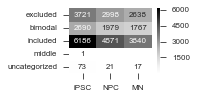

In [17]:
fig, ax= plt.subplots(figsize=(2.75, 1.5))
mask = modalities_counts_2d.isnull()
sns.heatmap(modalities_counts_2d, annot=True, mask=mask, fmt='g', annot_kws=dict(size=8), cmap='Greys')
ax.set(xlabel='', ylabel='')
fig.tight_layout()
fig.savefig('{}/modalities_counts_heatmap.pdf'.format(folder))

In [18]:
modalities_counts['percentage'] = 100*modalities_counts.groupby('phenotype')['# AS events'].apply(lambda x: x/x.sum())
modalities_counts

,phenotype,modality,# AS events,percentage
0,MN,bimodal,1767,21.387073
1,MN,excluded,2638,31.929315
2,MN,included,3840,46.477850
3,MN,uncategorized,17,0.205761
4,NPC,bimodal,1979,20.681367
5,NPC,excluded,2998,31.330338
6,NPC,included,4571,47.768837
7,NPC,uncategorized,21,0.219459
8,iPSC,bimodal,2690,21.229579
9,iPSC,excluded,3721,29.366269


## Barplots
### Split axes

/home/obotvinnik/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2894: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)


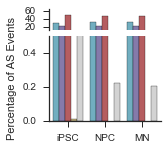

In [19]:
sns.set(style='ticks')
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(2, 2), gridspec_kw=dict(hspace=0.1, height_ratios=[0.2, 0.8]))

ax = axes[0]
sns.barplot(x='phenotype', hue='modality', y='percentage', data=modalities_counts, ax=ax,
            hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, x_order=study.phenotype_order)
ax.legend_.set_visible(False)
ax.locator_params('y', nbins=4)
sns.despine(ax=ax, bottom=True)
ax.tick_params(axis='x', bottom='off')
ax.set(xticks=[], xlabel='', ylim=(10, 65), ylabel='') #yticks=[10, 50, ])

ax = axes[1]
sns.barplot(x='phenotype', hue='modality', y='percentage', data=modalities_counts, ax=ax,
           hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, x_order=study.phenotype_order)
ax.set(ylim=(0, 0.5), ylabel='Percentage of AS Events', 
       xlabel='')
ax.legend_.set_visible(False)
ax.locator_params('y', nbins=4)
sns.despine(ax=ax)
# fig.tight_layout()
fig.savefig('{}/modalities_barplot.pdf'.format(folder))

### Large plot with zoom

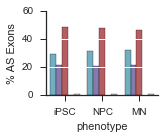

In [20]:
fig, ax = plt.subplots(figsize=(2, 1.5))

# ax = axes[0]
sns.barplot(x='phenotype', hue='modality', y='percentage', data=modalities_counts, ax=ax,
            hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, x_order=study.phenotype_order, zorder=-1)
ax.legend_.set_visible(False)
ax.locator_params('y', nbins=4)
ax.set(ylabel='% AS Exons')
ax.grid(axis='y', color='white', zorder=100)
sns.despine()
fig.savefig('{}/modalities_barplot.pdf'.format(folder))

# ax.set(ylim=(0, 0.3))
# # ax.grid(axis='y', color='grey', zorder=np.inf)
# fig.savefig('{}/modalities_barplot_zoom.pdf'.format(folder))



## Compare with the non-outlier calculation

In [21]:
non_outlier_counts = study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']).size()